# Notebook for testing procedure


## Load packages and setup CUDA device

In [1]:
# import packages
import torch
import os
import sys
import time
import hydra
import random
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

from gstools.random import MasterRNG
from functools import partial
from tqdm import tqdm

sys.path.append("../")
# from CNN_model_function.model import *
from utils import *
from model import *
# set seed
np.random.seed(10)
random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

# set device
# print("Current working directory: {0}".format(os.getcwd()))
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda")

## Load configurations

In [2]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="./"):
    cfg = compose("plot_50_particles")

## load data

In [3]:
# set grid
x = torch.arange(cfg.params.ox, cfg.params.nx)
z = torch.arange(cfg.params.oz, cfg.params.nz)
t = torch.arange(cfg.params.ot, cfg.params.nt) * cfg.params.dt

Z, X = torch.meshgrid(z, x)

In [4]:
# Load the true model
model_true = load_velocity_model(cfg, device=device)
m_vmin, m_vmax = (
    model_true.detach().cpu().numpy().min(),
    model_true.detach().cpu().numpy().max(),
)
print(f"True model min: {m_vmin:.2f}, max: {m_vmax:.2f}")

# create mask for water layer
msk = mask(model_true, water_velocity=1.5, device=device)

plt.figure(figsize=(10, 4))
# plot true model
plt.imshow(model_true.detach().cpu().numpy(), 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'true-model.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

True model min: 1.48, max: 5.69


In [5]:
# define model
input_channel  = 1
output_channel = 1
n_condition    = cfg.params.num_particles
n_feat   = 512
n_cfeat  = cfg.params.num_particles
model = CONTEXT_UNET(in_channels=input_channel, out_channels=output_channel, n_feat=n_feat, n_cfeat=n_cfeat, feature=[4, 8, 16, 32, 64]).to(device)

model_file  = './Dip_pretrain_small_model_iter2000_much_small.pth.tar'
state = torch.load(model_file)
model.load_state_dict(state['state_dict'])
cnnmodel = model.to(device)

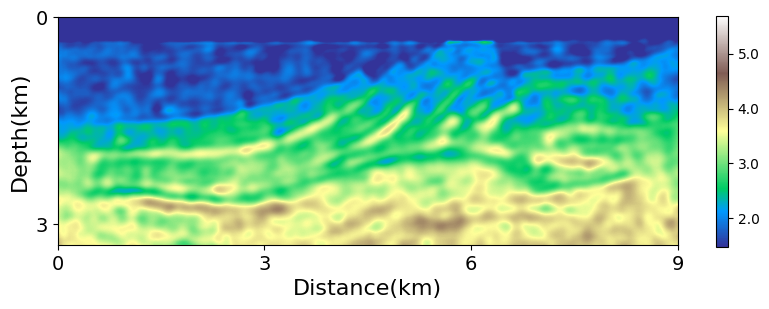

In [6]:
data1 = torch.randn([1, 1, cfg.params.nz, cfg.params.nx]).to(device)
data2 = torch.eye(cfg.params.num_particles).to(device)
output0=cnnmodel(data1,data2[0])
output1=cnnmodel(data1,data2[1])
# output2=cnnmodel(data1,data2[2])

imag0 = output0.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx)
# model1 plot
m_vmin, m_vmax = (
    model_true.detach().cpu().numpy().min(),
    model_true.detach().cpu().numpy().max(),
)
g_min = m_vmin
g_max = m_vmax

plt.figure(figsize=(10, 4))

plt.imshow(imag0, cmap="terrain", vmin=g_min, vmax=g_max,extent=[x[0], x[-1], z[-1], z[0]])
#plt.colorbar(shrink=0.5)
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
#plt.savefig(cfg.paths.figure_path+'condition20_iter'+str(i2)+'.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

tensor([[0.8000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


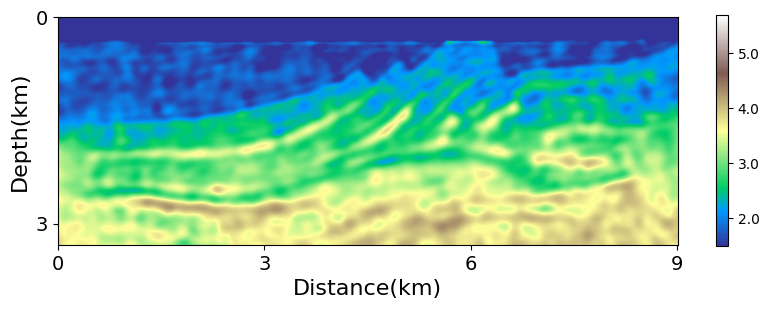

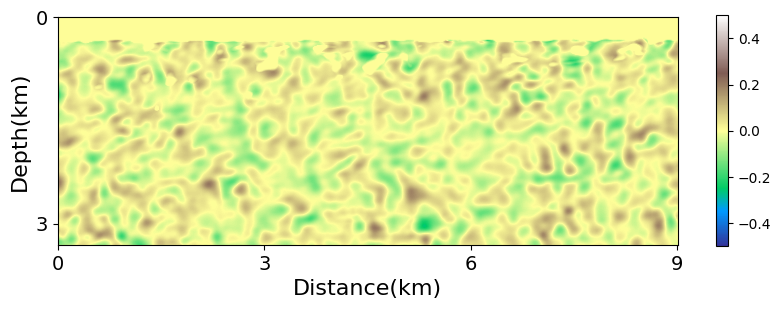

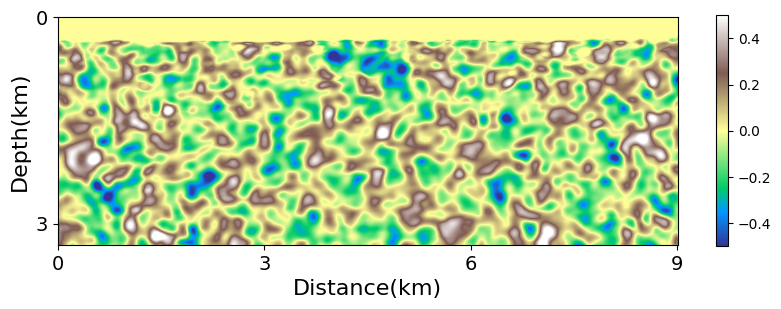

In [7]:
data3 = torch.zeros(1, 50).to(device)
data3[0,0]=0.8
data3[0,1]=0.2
print(data3)
output_3=cnnmodel(data1,data3).to(device)
diff0 = output_3 - output0
diff1 = output_3 - output1
diff_vmin = -0.5
diff_vmax = 0.5


# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_3.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-1.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff0.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-2.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-3.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

tensor([[0.8000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


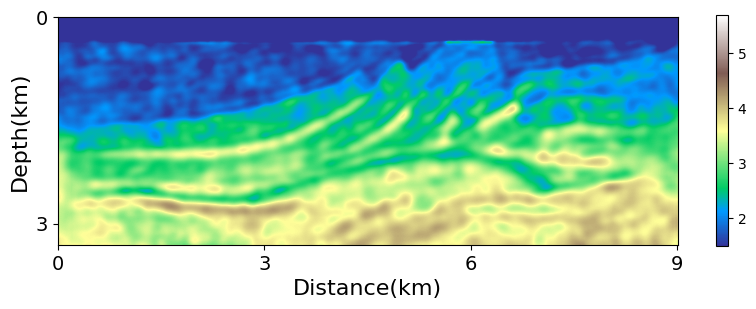

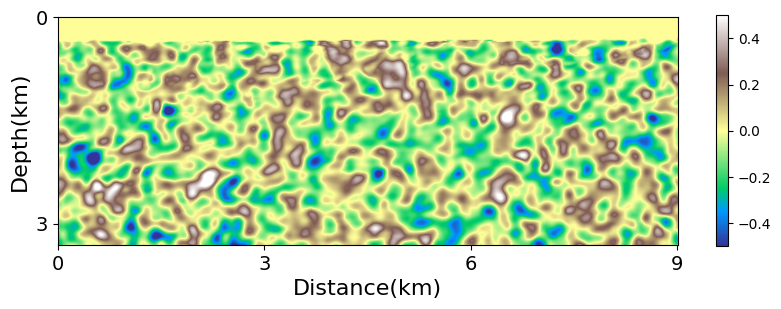

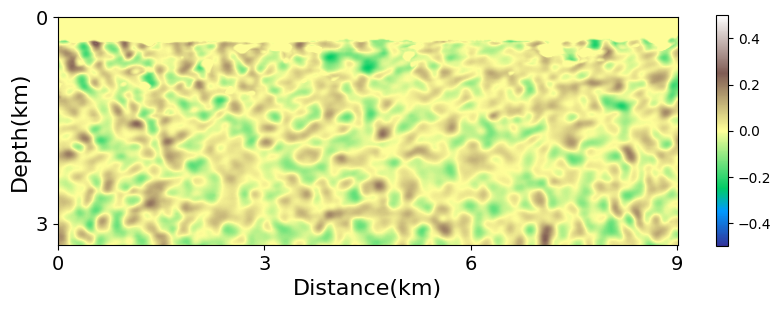

In [8]:
data4 = torch.zeros(1, 50).to(device)
data4[0,0]=0.2
data4[0,1]=0.8
print(data3)
output_4=cnnmodel(data1,data4).to(device)
diff3 = output_4 - output0
diff4 = output_4 - output1

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_4.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-4.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff3.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),            
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-5.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff4.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig3-6.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

### GRF

In [9]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="./"):
    cfg = compose("plot_50_particles")

Loaded model from ../data/deterministic_fwi_result.npy


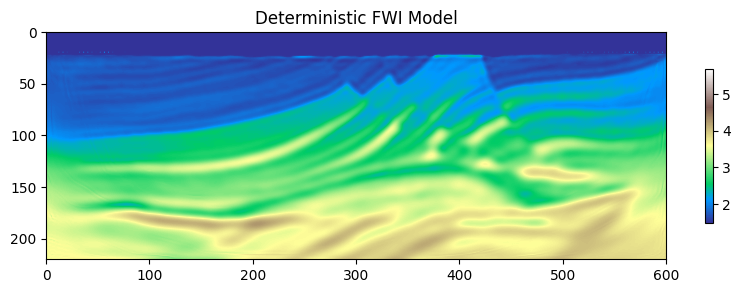

In [10]:
# load the deterministic optimization results
model_fwi = np.load(f"{cfg.paths.fwi_model_path}")
print(f"Loaded model from {cfg.paths.fwi_model_path}")

plt.figure(figsize=(10, 4))
# plot the deterministic optimization results
plt.imshow(model_fwi, 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.title('Deterministic FWI Model')
plt.colorbar(shrink=0.5)

In [11]:
# ADD GRF Term
rf = gs.Matern(dim=2, var=2.5e-2, len_scale=5, nu=1.25)
srf = gs.SRF(rf)
srf.set_pos([z, x], "structured")

grf_seed = MasterRNG(20170590)
for i in range(cfg.params.num_particles):
    srf(seed=grf_seed(), store=f"better_field{i}")

# generate initial model
grf = torch.from_numpy(np.array(srf)).float().reshape(cfg.params.num_particles, -1)
X_init = torch.from_numpy(model_fwi)
X_init = X_init.reshape(1, -1).repeat(cfg.params.num_particles, 1)
X_init = (X_init + grf).to(device)

with torch.no_grad():
    X_init = X_init * msk.reshape(1, -1)
    X_init[:, model_true.flatten() <= 1.5] = 1.5
    initial_particles = X_init.clone().detach().cpu().numpy()
    X_init.clamp_(m_vmin, m_vmax)
X_init.requires_grad = True

### Diff with GRF

In [12]:
X_init.shape

torch.Size([50, 132821])

In [13]:
grf.shape

torch.Size([50, 132821])

In [14]:
output_condition0=cnnmodel(data1,data2[0])
output_condition0.shape

torch.Size([1, 1, 221, 601])

In [15]:
msk

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

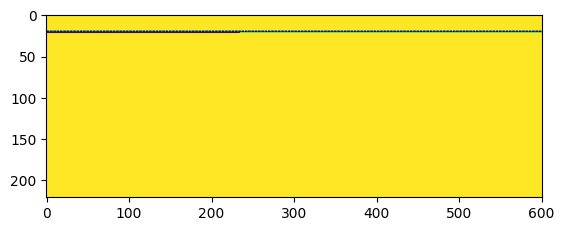

In [16]:
plt.imshow(msk.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx))

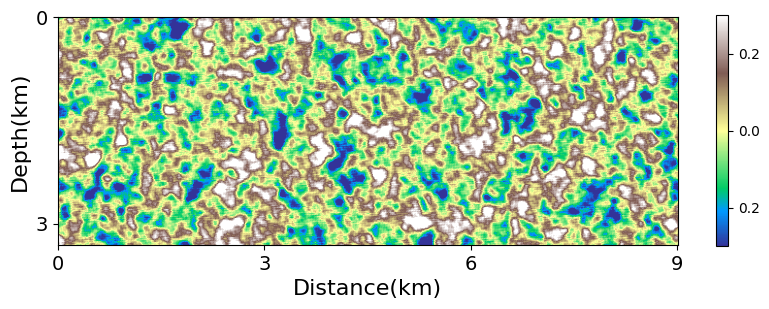

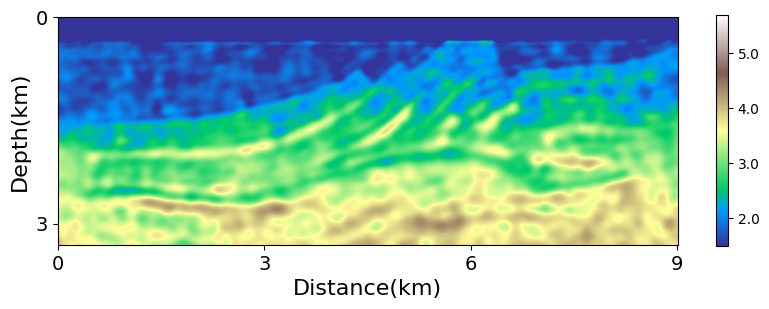

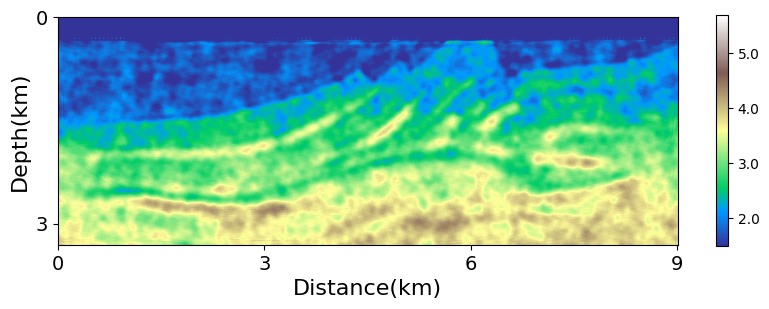

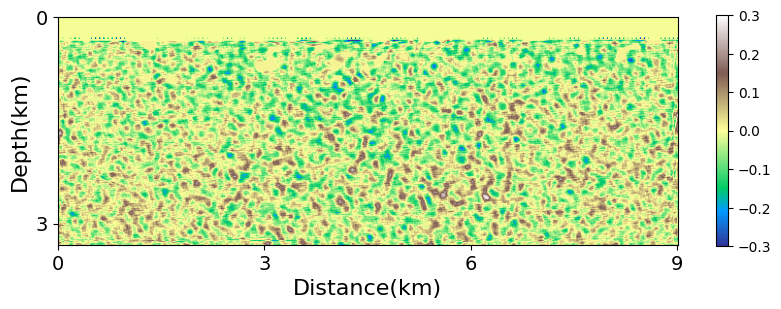

In [17]:
output_condition0=cnnmodel(data1,data2[0])
model_condition0 = X_init[0,:]
grf_condition0   = grf[0,:]
diff1 = output_condition0.reshape(cfg.params.nz,cfg.params.nx) - model_condition0.reshape(cfg.params.nz,cfg.params.nx)

diff_vmin = -0.3
diff_vmax =  0.3

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(grf_condition0.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(-0.2, 0.2, 3))  # Example ticks
colorbar.set_ticklabels(['0.2', '0.0', '0.2'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'grf0.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)


# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_condition0.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-1.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(model_condition0.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax,  
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-2.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-3.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

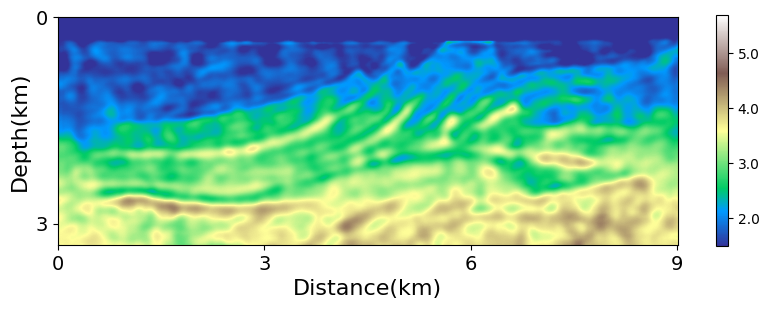

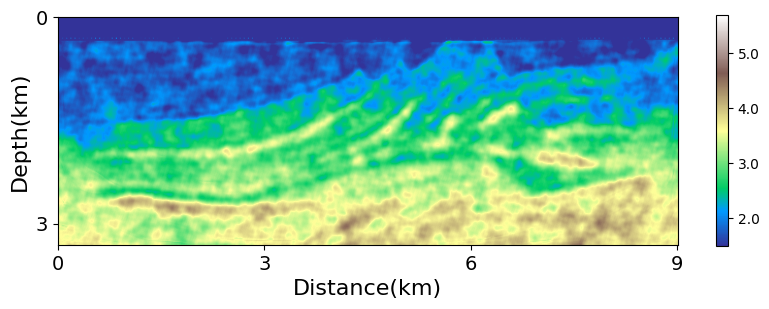

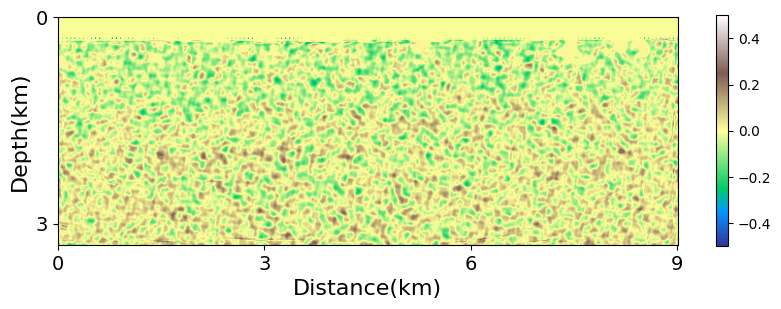

In [18]:
output_condition1=cnnmodel(data1,data2[15])
model_condition1 = X_init[15,:]
diff1 = output_condition1.reshape(cfg.params.nz,cfg.params.nx) - model_condition1.reshape(cfg.params.nz,cfg.params.nx)

diff_vmin = -0.5
diff_vmax = 0.5


# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-4.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(model_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax,  
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-5.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-6.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

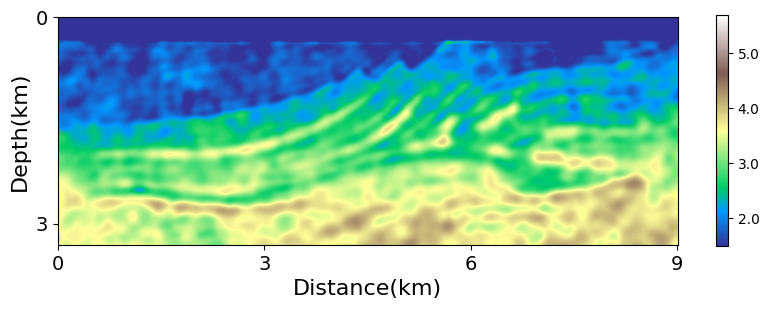

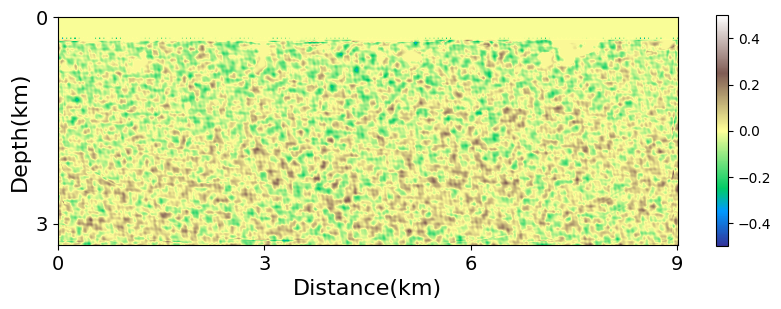

In [19]:
output_condition1=cnnmodel(data1,data2[30])
model_condition1 = X_init[30,:]
diff1 = output_condition1.reshape(cfg.params.nz,cfg.params.nx) - model_condition1.reshape(cfg.params.nz,cfg.params.nx)

diff_vmin = -0.5
diff_vmax = 0.5


# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-7.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(model_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax,  
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-8.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-9.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

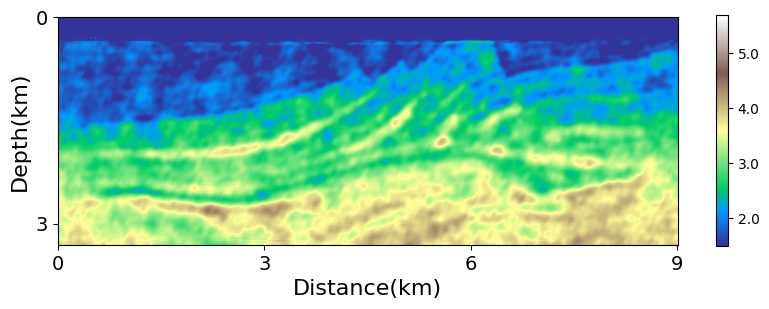

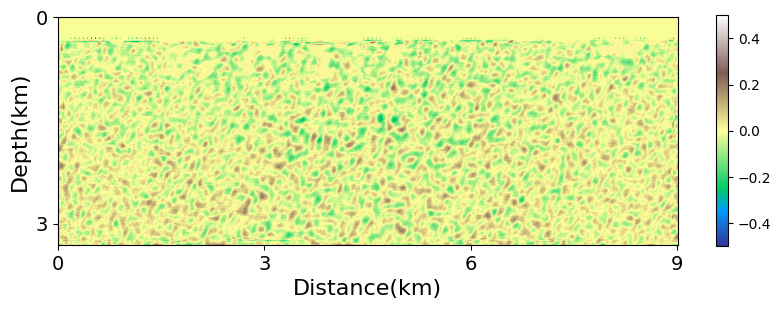

In [20]:
output_condition1=cnnmodel(data1,data2[45])
model_condition1 = X_init[45,:]
diff1 = output_condition1.reshape(cfg.params.nz,cfg.params.nx) - model_condition1.reshape(cfg.params.nz,cfg.params.nx)

diff_vmin = -0.5
diff_vmax = 0.5

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(output_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax, 
            cmap='terrain',
            )
plt.gca().set_visible(False)
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-10.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(model_condition1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=m_vmin, 
            vmax=m_vmax,  
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-11.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)

# model1 plot
plt.figure(figsize=(10,4))
plt.imshow(diff1.detach().cpu().numpy().reshape(cfg.params.nz,cfg.params.nx),
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            cmap='terrain',
            )
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
# colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
# colorbar.set_ticklabels(['2.0', '3.0', '4.0','5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig(cfg.paths.figure_path+'fig5-12.pdf', dpi=500,bbox_inches='tight',pad_inches=0.1)